In [1]:
from langchain_neo4j import Neo4jVector
from langchain_ollama import OllamaEmbeddings
import matplotlib.colors as mcolors
import pandas as pd

import sys
sys.path.append('/home/TomKerby/Research/lit_review/lit_review')
import utils

sys.path.append('/home/TomKerby/Research/lit_review/configs')
from rag_config import config

kg = utils.load_kg(config)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
import datetime

def plot_pca_embeddings(x_axis, y_axis, color_vector, 
                        is_categorical=False, is_date=False, norm=None, cmap=None,
                        fig_size=(8, 6), marker_size=70, alpha=0.7,
                        title="PCA of Abstract Embeddings", 
                        xlabel="Principal Component 1", ylabel="Principal Component 2",
                        return_fig=True, **kwargs):
    """
    Plots PCA-reduced embeddings with customizable color mapping for categorical,
    continuous, or date values. This function is designed to be flexible for use as
    a backend in an application.

    Parameters:
    -----------
    color_vector : array-like
        A numeric array (or list) representing colors. For dates (is_date=True),
        these should be numeric timestamps (e.g. seconds since epoch) with np.nan for missing dates.
    is_categorical : bool, optional
        If True, treat color_vector as categorical labels (default: False).
    is_date : bool, optional
        If True, treat color_vector as date values. Handles missing dates and applies a date formatter (default: False).
    norm : Normalize instance, optional
        A Normalize instance for date values. If None and is_date is True, one will be computed.
    cmap : str or Colormap, optional
        The colormap to use. Defaults: 'viridis' for continuous/date, 'tab10' for categorical.
    fig_size : tuple, optional
        Size of the matplotlib figure (default: (8, 6)).
    marker_size : int, optional
        Size of the markers in the scatter plot.
    alpha : float, optional
        Alpha transparency for the scatter points.
    title : str, optional
        Title for the plot.
    xlabel : str, optional
        Label for the x-axis.
    ylabel : str, optional
        Label for the y-axis.
    return_fig : bool, optional
        If True, returns the matplotlib figure instead of calling plt.show().
    **kwargs :
        Additional keyword arguments for customization (e.g., extra parameters to plt.scatter).

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure object.
    """
        
    fig, ax = plt.subplots(figsize=fig_size)
    
    if is_date:
        color_vector = np.array(color_vector)
        valid_mask = ~np.isnan(color_vector)
        cmap = cmap if cmap is not None else 'viridis'
        if norm is None:
            valid_dates = color_vector[valid_mask]
            norm = Normalize(vmin=np.min(valid_dates), vmax=np.max(valid_dates))
        sc_valid = ax.scatter(
            x_axis[valid_mask],
            y_axis[valid_mask],
            c=color_vector[valid_mask],
            cmap=cmap,
            norm=norm,
            s=marker_size,
            alpha=alpha,
            **kwargs
        )
        if not np.all(valid_mask):
            ax.scatter(
                x_axis[~valid_mask],
                y_axis[~valid_mask],
                color='red',
                s=marker_size,
                alpha=alpha,
                label='Missing date'
            )
        cbar = fig.colorbar(sc_valid, ax=ax, label='Date')
        cbar.ax.yaxis.set_major_formatter(FuncFormatter(
            lambda x, pos: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d") if not np.isnan(x) else ""
        ))
    elif is_categorical:
        categories, labels = np.unique(color_vector, return_inverse=True)
        cmap = 'tab10'
        sc = ax.scatter(
            x_axis, 
            y_axis,
            c=labels, 
            cmap=cmap,
            s=marker_size,
            alpha=alpha,
            **kwargs
        )
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', 
                       markerfacecolor=plt.cm.get_cmap(cmap)(i), markersize=8, label=str(cat))
            for i, cat in enumerate(categories)
        ]
        ax.legend(handles=handles, title='Category')
    else:
        cmap = cmap if cmap is not None else 'viridis'
        sc = ax.scatter(
            x_axis, 
            y_axis,
            c=color_vector,
            cmap=cmap,
            s=marker_size,
            alpha=alpha,
            **kwargs
        )
        fig.colorbar(sc, ax=ax, label='Value')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    
    # Instead of showing the plot, return the figure for further processing.
    if return_fig:
        return fig
    else:
        plt.show()
        
def process_color_vector(raw_color_data, mode, date_format="%Y-%m-%d", compute_norm=False, **kwargs):
    """
    Processes raw color data into a format suitable for plotting in one of three modes:
      - 'categorical': expects labels (e.g., ['DM', 'GAN', ...])
      - 'continuous': expects numerical values (e.g., citation counts)
      - 'date': expects date strings which will be converted to Unix timestamps
    
    Parameters:
    -----------
    raw_color_data : array-like
        The raw data extracted from document metadata.
    mode : str
        One of 'categorical', 'continuous', or 'date'.
    date_format : str, optional
        The format to use when parsing dates (default: "%Y-%m-%d").
    compute_norm : bool, optional
        For mode 'date': if True, computes and returns a matplotlib Normalize instance 
        based on valid date values (default: False).
    **kwargs:
        Any additional keyword arguments for further customization.
    
    Returns:
    --------
    processed : np.array or list
        The processed color vector.
    norm : matplotlib.colors.Normalize or None
        For mode 'date': returns a Normalize instance if compute_norm is True, otherwise None.
        For other modes, always returns None.
    """
    if mode == 'categorical':
        # Simply convert to list (or np.array) of labels.
        processed = list(raw_color_data)
        norm = None

    elif mode == 'continuous':
        # Convert to a float array.
        processed = np.array(raw_color_data, dtype=float)
        norm = None

    elif mode == 'date':
        # Convert the raw data to a pandas Series and then to datetime.
        dates_series = pd.to_datetime(pd.Series(raw_color_data), format=date_format, errors='coerce')
        # Convert datetime values to Unix timestamp (seconds)
        # Note: dates_series.astype('int64') converts to nanoseconds.
        date_ints = dates_series.astype('int64')
        # Some NaT values turn into the minimum int64; replace those with NaN.
        date_ints = date_ints.where(date_ints != np.iinfo('int64').min)
        # Convert from nanoseconds to seconds.
        processed = date_ints / 1e9
        norm = None
        if compute_norm:
            valid_mask = ~dates_series.isna()
            if valid_mask.any():
                vmin = processed[valid_mask].min()
                vmax = processed[valid_mask].max()
                norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Invalid mode. Choose 'categorical', 'continuous', or 'date'.")

    return processed, norm

In [3]:
vis_query = """
MATCH (p:Paper)
WHERE p.abstract IS NOT NULL AND p.abstract <> ''
WITH DISTINCT p, vector.similarity.cosine(p.abstractEmbedding, $embedding) AS score
ORDER BY score DESC LIMIT $k
RETURN p.abstract AS text, score, properties(p) AS metadata
"""

abstract_vector = Neo4jVector.from_existing_index(
    OllamaEmbeddings(model=config['embedding']['model_id']),
    graph=kg, 
    index_name='abstract_embeddings',
    embedding_node_property='abstractEmbedding',
    text_node_property='abstract',
    retrieval_query=vis_query,
)

# Plotting GAN vs DM papers

In [4]:
def generate_plot_from_query(
    query,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=None
):
    query = ["search_query: " + q for q in query]
    if labels is not None:
        full_labels = []
        for l in labels:
            full_labels.extend([l] * n_docs)
        labels = full_labels
    
    all_embeddings = []
    all_citation_counts = []
    all_dates = []
    
    for q in query:
        retrieved_docs = abstract_vector.similarity_search_with_score(q, k=n_docs)
        
        embeddings = np.array([doc.metadata.get("abstractEmbedding") for doc, _ in retrieved_docs])
        citation_counts = np.array([doc.metadata.get("citationCount") for doc, _ in retrieved_docs])
        dates = np.array([doc.metadata.get("publicationDate") for doc, _ in retrieved_docs])
        
        all_embeddings.append(embeddings)
        all_citation_counts.append(citation_counts)
        all_dates.append(dates)
    
    if len(query) > 1:  
        embeddings = np.concatenate(all_embeddings, axis=0)
        citation_counts = np.concatenate(all_citation_counts, axis=0)
        dates = np.concatenate(all_dates, axis=0)
    
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    
    if color_var == 'labels' and labels is not None:
        labels, _ = process_color_vector(labels, mode='categorical')
        plot_pca_embeddings(reduced_embeddings[:,x_axis_comp], reduced_embeddings[:,y_axis_comp], labels, is_categorical=True, return_fig=False)
    elif color_var == 'citationCount':
        citation_counts, _ = process_color_vector(citation_counts, mode='continuous')
        plot_pca_embeddings(reduced_embeddings[:,x_axis_comp], reduced_embeddings[:,y_axis_comp], citation_counts, is_categorical=False, return_fig=False)
    elif color_var == 'dates':
        dates, norm = process_color_vector(dates, mode='date', date_format="%Y-%m-%d", compute_norm=True)
        plot_pca_embeddings(reduced_embeddings[:,x_axis_comp], reduced_embeddings[:,y_axis_comp], dates, is_date=True, norm=norm, cmap='viridis', return_fig=False)
    else:
        raise Exception(f'color_var must be one of: labels, citationCount, dates. Current value is {color_var}')

/tmp/ipykernel_2898062/2287801609.py:101: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  markerfacecolor=plt.cm.get_cmap(cmap)(i), markersize=8, label=str(cat))


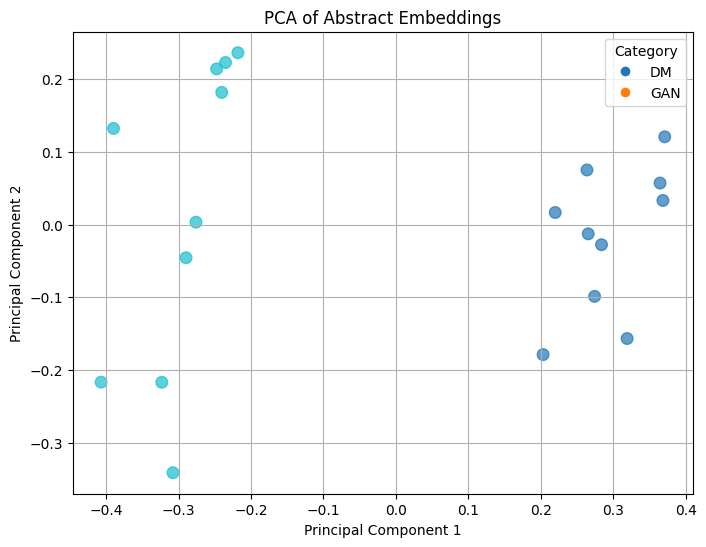

In [5]:
query = ["Papers that discuss methods applied to diffusion models.", "Papers that discuss methods applied to GANs."]
color_var = "labels"

generate_plot_from_query(
    query,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=["DM", "GAN"]
)

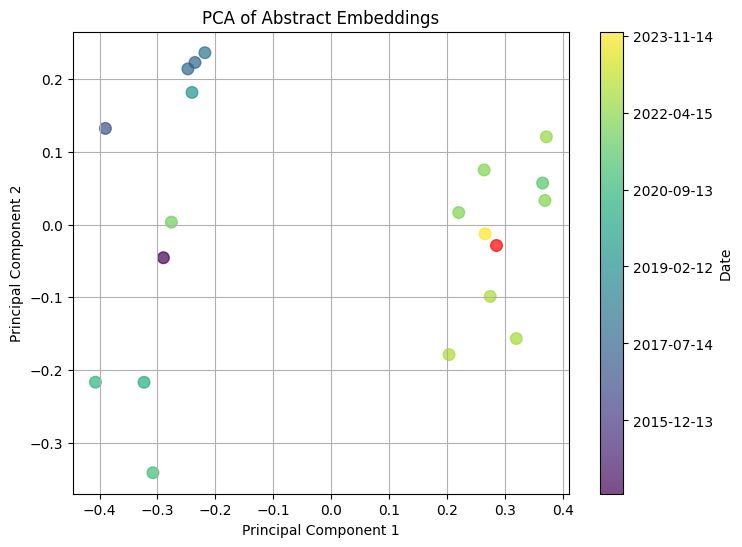

In [6]:
query = ["Papers that discuss methods applied to diffusion models.", "Papers that discuss methods applied to GANs."]
color_var = "dates"

generate_plot_from_query(
    query,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=["DM", "GAN"]
)

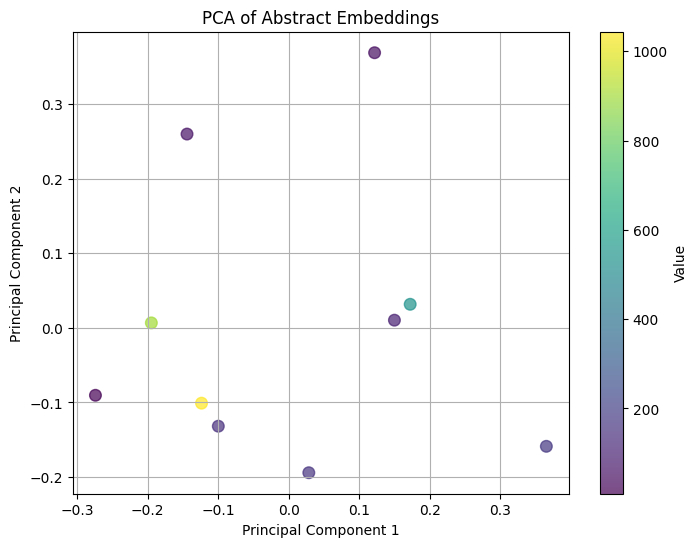

In [7]:
query = ["Papers that discuss methods applied to diffusion models."]
color_var = "citationCount"

generate_plot_from_query(
    query,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=None
)

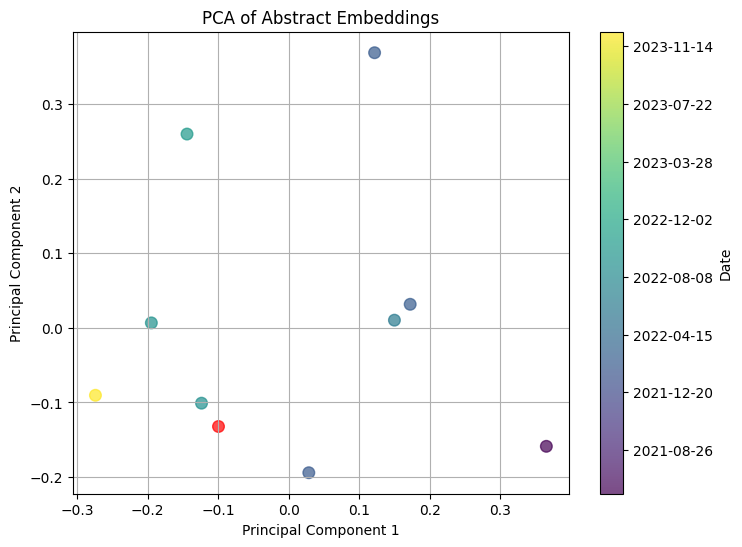

In [8]:
query = ["Papers that discuss methods applied to diffusion models."]
color_var = "dates"

generate_plot_from_query(
    query,
    color_var,
    x_axis_comp=0,
    y_axis_comp=1,
    n_docs=10,
    n_components=.95,
    labels=None
)

In [9]:
# import io
# import base64

# # Generate the figure
# fig = plot_pca_embeddings(embeddings, date_floats, is_date=True, norm=norm, cmap='viridis')

# # Save figure to a buffer
# buf = io.BytesIO()
# fig.savefig(buf, format='png')
# buf.seek(0)
# encoded_img = base64.b64encode(buf.read()).decode('utf-8')